# assignment 1

> Joshua Schmidt

_I pledge my honor that I have abided by the Stevens Honor System_

The purpose of this assignment was to categorize using Logistic Regression and multi-layer perceptrons the author a given text is written by. There are three categories that the text can be placed into (based on the author's name): "Fyodor Dostoyevsky", "Arthur Conan Doyle", and "Jane Austen".

## Derivation

The derivation iframe does not show up automatically. You will need to run the cell to view the pdf below. Otherwise you can view the pdf by opening the `proof/assignment_1_derivation.pdf` file.

In [1]:
from IPython.display import IFrame
IFrame("../proof/assignment_1_derivation.pdf", width=800, height=800)

## Utilities

The first code I wrote includes utility functions. In this case, the `utils.py` file contains `get_glob`, used to get files based off of a path relative to the root directory:

In [1]:
#!/usr/bin/env python3
"""
utils functions (utils.py)
"""

from glob import glob
from os.path import abspath, join
from loguru import logger
from typing import List
from pathlib import Path


def get_glob(glob_rel_path: str) -> List[str]:
    """
    get glob file list for given path
    """
    logger.info("getting files using glob")
    complete_path: str = join(
        abspath(join(Path(__file__).absolute(), '../..')), glob_rel_path)
    files = glob(complete_path)
    return files


The next file contains an object outlining a Book object, along with metadata about each book. An enumeration is used to define each book, and dictionaries are used to link the enum to the class name and a StartEnd object. This object contains the start and end line numbers for the useful lines. Without these start and end line numbers, it would be difficult to exclude parts of the book like the Table of Contents, for example, which are not paragraphs.

In [2]:
#!/usr/bin/env python3
"""
classification type (books.py)
"""

from enum import Enum
from typing import Dict


class BookType(Enum):
    """
    Enum to store nlp types
    """
    dostoyevsky = "dostoyevsky"
    doyle = "doyle"
    austen = "austen"


class StartEnd:
    """
    start and end lines for book
    """

    def __init__(self, start: int, end: int):
        self.start = start
        self.end = end


start_end_map: Dict[BookType, StartEnd] = {
    BookType.dostoyevsky: StartEnd(186, 35959),
    BookType.doyle: StartEnd(62, 12681),
    BookType.austen: StartEnd(94, 80104),
}

class_map: Dict[BookType, str] = {
    BookType.dostoyevsky: 'Fyodor Dostoyevsky',
    BookType.doyle: 'Arthur Conan Doyle',
    BookType.austen: 'Jane Austen',
}


## Cleaning

In the cleaning function, each file is read, processed, and saved to a Pandas DataFrame for later use. The glob utility function mentioned earlier is used to get the file paths, and the lines are read one by one using a `while True` loop. All text is converted to lower case, but the text retains this punctuation. The reasoning behind this is that some authors may use more quotes because they have more dialogue in their stories, such as in Sherlock Holmes, and therefore the punctuation would help with classification. However, upper-case characters will most likely not help in distinguishing one author's text from another. Additionally, subsequent lines that include quotes, such as back-and-forth dialogue, are considered part of the same paragraph, and are treated as such by this algorithm. Lines that start with "Chapter" or "ADVENTURE" are excluded, and books stop when either the stop line number is reached or ending strings are found ("the end" or "end of this project gutenberg book"). This makes the cleaning fairly resilient to processing new inputs. At the end of the cleaning, a sample of the dataframe is outputted to show some of the cleaned data.

In [3]:
#!/usr/bin/env python3
"""
data clean (clean.py)
"""

from os.path import basename, splitext
from typing import Optional, List
from utils import get_glob
from variables import data_folder, paragraph_key, label_key, random_state, class_key
from loguru import logger
from books import BookType, start_end_map, class_map
import pandas as pd
from typing import Tuple

title_split: str = 'title: '
author_split: str = 'author: '

start_book: str = 'start of this project gutenberg ebook'
the_end: str = 'the end'
end_book: str = 'end of this project gutenberg ebook'

chapter: str = 'Chapter '
adventure: str = 'ADVENTURE '
multi_quote_identifier: str = '"'

min_line_len: int = 6  # line discarded if less than this number of characters


def clean() -> Tuple[pd.DataFrame, List[BookType]]:
    """
    data cleaning
    """
    data: pd.DataFrame = pd.DataFrame()
    class_count: int = 0
    label_list: List[BookType] = []

    # preprocess data and construct examples
    for file_path in get_glob(f'{data_folder}/*.txt'):
        file_name: str = basename(splitext(file_path)[0])
        logger.info(f'processing {file_name}')
        title: Optional[str] = None
        book_key: Optional[BookType] = None
        book_started: bool = False
        paragraphs: List[List[str]] = []
        num_newline_count: int = 0
        line_number: int = 0
        with open(file_path, 'r') as current_file:
            while True:
                line = current_file.readline()
                line_number += 1
                line_lower_trim: Optional[str] = None
                if line:
                    line_lower_trim = line.lower().strip()
                if not book_started and \
                    ((line_lower_trim is not None and line_lower_trim.startswith(start_book))
                     or (book_key is not None and line_number >= start_end_map[book_key].start)):
                    book_started = True
                if line_lower_trim is None or line_lower_trim.startswith(end_book) \
                        or line_lower_trim == the_end or \
                        (book_key is not None and line_number >= start_end_map[book_key].end):
                    # done with reading the file
                    break
                if not book_started:
                    if title is None and line_lower_trim.startswith(title_split):
                        title = line_lower_trim.split(title_split)[1]
                        logger.info(f'title: {title}')
                    if book_key is None and line_lower_trim.startswith(author_split):
                        author: str = line_lower_trim.split(author_split)[1]
                        logger.info(f'author: {author}')
                        book_key = BookType(author.split(' ')[-1])
                else:
                    if len(line_lower_trim) < min_line_len or \
                            line.startswith(chapter) or line.startswith(chapter):
                        num_newline_count += 1
                    else:
                        multi_line_quotes = line_lower_trim.startswith(multi_quote_identifier) \
                            and paragraphs[-1][0].startswith(multi_quote_identifier)
                        if len(paragraphs) == 0 or \
                                (num_newline_count > 0 and not multi_line_quotes):
                            paragraphs.append([])
                        num_newline_count = 0
                        paragraphs[-1].append(line_lower_trim)
        if book_key is None:
            raise RuntimeError('no book key found')
        class_name = class_map[book_key]
        logger.info(
            f'number of paragraphs in class "{class_name}": {len(paragraphs)}')
        data = pd.concat([data, pd.DataFrame({
            paragraph_key: [' '.join(paragraph) for paragraph in paragraphs],
            label_key: [class_name] * len(paragraphs),
            class_key: class_count
        })], ignore_index=True)
        label_list.append(book_key)
        class_count += 1
    logger.info(
        f'\nsample of output data:\n{data.sample(random_state=random_state, n=5)}')
    return data, label_list


#if __name__ == '__main__':
#    clean()


In [4]:
clean_data, label_list = clean()

2020-09-24 17:22:28.974 | INFO     | utils:get_glob:17 - getting files using glob
2020-09-24 17:22:28.976 | INFO     | __main__:clean:40 - processing austen
2020-09-24 17:22:28.976 | INFO     | __main__:clean:66 - title: the complete project gutenberg works of jane austen
2020-09-24 17:22:28.977 | INFO     | __main__:clean:69 - author: jane austen
2020-09-24 17:22:29.022 | INFO     | __main__:clean:86 - number of paragraphs in class "Jane Austen": 2497
2020-09-24 17:22:29.026 | INFO     | __main__:clean:40 - processing dostoyevsky
2020-09-24 17:22:29.027 | INFO     | __main__:clean:66 - title: the brothers karamazov
2020-09-24 17:22:29.028 | INFO     | __main__:clean:69 - author: fyodor dostoyevsky
2020-09-24 17:22:29.086 | INFO     | __main__:clean:86 - number of paragraphs in class "Fyodor Dostoyevsky": 5840
2020-09-24 17:22:29.092 | INFO     | __main__:clean:40 - processing doyle
2020-09-24 17:22:29.094 | INFO     | __main__:clean:66 - title: the adventures of sherlock holmes
2020-0

## Training

### Logistic Regression

There are two different types of logistic regression algorithms that were required for this assignment - mini-batch gradient descent logistic regression, and stochastic gradient descent logistic regression. In my first implementation of the logistic regression algorithm, I mistakenly used batch gradient descent, thinking that it would easily translate to mini-batch. Unfortunately, the specific implementation I used, while very efficient, is difficult to port to mini-batch. This is because I used a minimization function - "bfgs" to be specific, to minimize the loss. Using the minimization function requires a different gradient function than for mini-batch. Therefore, I needed to create a completely different implementation to actually complete this assignment. The batch version is below.

In [2]:
#!/usr/bin/env python3
"""
minibatch logistic regression
"""

import numpy as np
# from loguru import logger
from sklearn.metrics import accuracy_score

# relative imports
#from books import start_end_map


def softmax(x, multi=True):
    """
    get the softmax
    """
    ex = np.exp(x - np.max(x))
    return ex / ex.sum(axis=1 if multi else 0)


def _process_labels(y_train):
    """
    process labels to array
    """
    res = []
    for val in y_train:
        res.append(np.zeros(3))
        res[-1][val] = 1
    return np.array(res)


class LogisticRegression:
    """
    logistic regression
    """

    def __init__(self, epochs=100, batch_size=32, lmbda=1e-4, plot_epoch_iter=1, **_args):
        """
        logistic regression init
        """
        self.epochs = epochs
        self.weights = None
        self.bias_matrix = None
        self.batch_size = batch_size
        self.lmbda = lmbda
        self.bias_vector = None
        self.plot_epoch_iter = plot_epoch_iter
        self.training_scores = None
        self.testing_scores = None

    def _regularization(self, index, k):
        return self.lmbda * (self.weights[index, k]**2)

    def _regularization_gradient(self, k):
        return 2 * self.lmbda * self.weights[:, k]

    def _net(self, Xi, multi=True):
        """
        Define out network and obtain a predicted output for a set of M inputs ( V > K )
        """
        y_linear = np.add(np.dot(Xi, self.weights), self.bias_vector[0])
        return softmax(y_linear, multi=multi)

    def score(self, X, y):
        """
        returns the accuracy score of the logistic regression function
        """
        try:
            return accuracy_score(y, self.predict(X))
        except ValueError:
            return 0.

    def predict(self, X):
        """
        get prediction for given array of inputs
        """
        X = X.toarray()
        res = []
        for elem in X:
            net_output = self._net(elem, multi=False)
            output = np.argmax(net_output[0])
            res.append(output)
        return res

    def fit(self, X_train_text, y_train, X_test_text, y_test):
        """
        main training loop
        """
        X_train = X_train_text
        X_train_text = X_train_text.toarray()
        y_train = _process_labels(y_train)
        N = X_train_text.shape[0]  # dataset length
        V = X_train_text.shape[1]  # vocabulary length
        K = len(start_end_map.keys()) # num of classes
        lr = 1e-2  # Learning rate
        self.weights = np.random.rand(V, K) # weight vector
        self.bias_vector = np.random.rand(1, K) # bias vector
        self.bias_matrix = np.repeat(
            self.bias_vector, self.batch_size, axis=0) # bias matrix

        dataset_len = X_train_text.shape[0]
        dataset_indexes = np.arange(dataset_len)
        training_scores = []
        testing_scores = []
        for epoch in range(self.epochs):
            # logger.info(f"Epoch: {epoch + 1}")
            epoch_loss = 0
            epoch_gradient = np.zeros((V, K))
            for _batch_index in range(0, N, self.batch_size):
                current_indices = np.random.choice(
                    dataset_indexes, self.batch_size, replace=False)
                X = X_train_text[current_indices]
                Y = y_train[current_indices]
                for index, Xi, Yi in zip(current_indices, X, Y):
                    Xi = Xi.reshape(1, V)
                    Yi = Yi.reshape(1, K)
                    yhat = self._net(Xi, multi=(
                        self.batch_size != 1)).reshape(1, K)
                    k_true = np.where(Yi[0] == 1)
                    # Prediction component of loss update
                    epoch_loss += -(1/N) * (np.dot(np.transpose(Yi), yhat))
                    # Prediction component of epoch gradient update
                    a = (np.transpose(Xi) @ (1-yhat))[:, k_true]
                    epoch_gradient[:,
                                   k_true] += a
                    # for all classes
                    for k in range(K):
                        # regularization update per class
                        epoch_loss += self._regularization(index, k)
                        epoch_gradient[:,
                                       k] += self._regularization_gradient(k)
            if (epoch + 1) % self.plot_epoch_iter == 0:
                training_scores.append(
                    self.score(X_train, y_train))
                testing_scores.append(
                    self.score(X_test_text, y_test))
            self.weights = self.weights - lr * epoch_gradient
        self.training_scores = training_scores
        self.testing_scores = testing_scores

    def get_train_test_scores(self):
        """
        get training and testing score data (for plotting)
        """
        return self.training_scores, self.testing_scores


#if __name__ == '__main__':
#    raise RuntimeError("logistic regression cannot be run on its own")


The final version of the logistic regression algorithm is shown below. In this version, I am not using a minimization function at all. Instead, I am using a learning rate with an iterative approach to handle the weight updates. The softmax, regularization, and regularization_gradient functions are all defined in the class function, so that they can access the object's current weights and working variables. This does not use any outside packages besides numpy, loguru (a logging library), and `accuracy_score` from scikit learn for validation. The main training loop is found in fit, and there is a getter for the training and testing scores that are produced during the training of the model.

In [1]:
#!/usr/bin/env python3
"""
minibatch logistic regression
"""

import numpy as np
# from loguru import logger
from sklearn.metrics import accuracy_score

# relative imports
#from books import start_end_map


def softmax(x, multi=True):
    """
    get the softmax
    """
    ex = np.exp(x - np.max(x))
    return ex / ex.sum(axis=1 if multi else 0)


def _process_labels(y_train):
    """
    process labels to array
    """
    res = []
    for val in y_train:
        res.append(np.zeros(3))
        res[-1][val] = 1
    return np.array(res)


class LogisticRegression:
    """
    logistic regression
    """

    def __init__(self, epochs=100, batch_size=32, lmbda=1e-4, plot_epoch_iter=1, **_args):
        """
        logistic regression init
        """
        self.epochs = epochs
        self.weights = None
        self.bias_matrix = None
        self.batch_size = batch_size
        self.lmbda = lmbda
        self.bias_vector = None
        self.plot_epoch_iter = plot_epoch_iter
        self.training_scores = None
        self.testing_scores = None

    def _regularization(self, index, k):
        return self.lmbda * (self.weights[index, k]**2)

    def _regularization_gradient(self, k):
        return 2 * self.lmbda * self.weights[:, k]

    def _net(self, Xi, multi=True):
        """
        Define out network and obtain a predicted output for a set of M inputs ( V > K )
        """
        y_linear = np.add(np.dot(Xi, self.weights), self.bias_vector[0])
        return softmax(y_linear, multi=multi)

    def score(self, X, y):
        """
        returns the accuracy score of the logistic regression function
        """
        try:
            return accuracy_score(y, self.predict(X))
        except ValueError:
            return 0.

    def predict(self, X):
        """
        get prediction for given array of inputs
        """
        X = X.toarray()
        res = []
        for elem in X:
            net_output = self._net(elem, multi=False)
            output = np.argmax(net_output[0])
            res.append(output)
        return res

    def fit(self, X_train_text, y_train, X_test_text, y_test):
        """
        main training loop
        """
        X_train = X_train_text
        X_train_text = X_train_text.toarray()
        y_train = _process_labels(y_train)
        N = X_train_text.shape[0]  # dataset length
        V = X_train_text.shape[1]  # vocabulary length
        K = len(start_end_map.keys()) # num of classes
        lr = 1e-2  # Learning rate
        self.weights = np.random.rand(V, K) # weight vector
        self.bias_vector = np.random.rand(1, K) # bias vector
        self.bias_matrix = np.repeat(
            self.bias_vector, self.batch_size, axis=0) # bias matrix

        dataset_len = X_train_text.shape[0]
        dataset_indexes = np.arange(dataset_len)
        training_scores = []
        testing_scores = []
        for epoch in range(self.epochs):
            # logger.info(f"Epoch: {epoch + 1}")
            epoch_loss = 0
            epoch_gradient = np.zeros((V, K))
            for _batch_index in range(0, N, self.batch_size):
                current_indices = np.random.choice(
                    dataset_indexes, self.batch_size, replace=False)
                X = X_train_text[current_indices]
                Y = y_train[current_indices]
                for index, Xi, Yi in zip(current_indices, X, Y):
                    Xi = Xi.reshape(1, V)
                    Yi = Yi.reshape(1, K)
                    yhat = self._net(Xi, multi=(
                        self.batch_size != 1)).reshape(1, K)
                    k_true = np.where(Yi[0] == 1)
                    # Prediction component of loss update
                    epoch_loss += -(1/N) * (np.dot(np.transpose(Yi), yhat))
                    # Prediction component of epoch gradient update
                    a = (np.transpose(Xi) @ (1-yhat))[:, k_true]
                    epoch_gradient[:,
                                   k_true] += a
                    # for all classes
                    for k in range(K):
                        # regularization update per class
                        epoch_loss += self._regularization(index, k)
                        epoch_gradient[:,
                                       k] += self._regularization_gradient(k)
            if (epoch + 1) % self.plot_epoch_iter == 0:
                training_scores.append(
                    self.score(X_train, y_train))
                testing_scores.append(
                    self.score(X_test_text, y_test))
            self.weights = self.weights - lr * epoch_gradient
        self.training_scores = training_scores
        self.testing_scores = testing_scores

    def get_train_test_scores(self):
        """
        get training and testing score data (for plotting)
        """
        return self.training_scores, self.testing_scores


#if __name__ == '__main__':
#    raise RuntimeError("logistic regression cannot be run on its own")


### Main Training Script

In the main training loop, the train function takes an input of the clean data dataframe, and a list of BookType enums with indexes corresponding to the class numbers in the dataframe. The first step is to initialize all the variables and objects that will be used in the loop. `StratifiedKFold` is used to split the training data into training and testing data in K Folds, and the `train_test_split` function is used to split the overall dataset into training and testing data beforehand. The clean paragraph text is converted into vectors using the `TfidfVectorizer` object, which is fitted over only the training data (as opposed to the entire corpus). Once this data is vectorized, it is ready for the training loop.

The main loop iterates over the K Folds in the training data. First, the unnecessary `BatchLogisticRegression` trains to give a reference to the other classification methods. Next, the options for lambda in the logistic regression are iterated over, used for training both the minibatch and sgd logistic regression classifiers. The best scoring model over all iterations of the outer loop is saved, along with its training and validation scores.

In the second inner for loop, the iteration is done over the hidden layers possible for the MLP model. Currently it is set for a single layer of 2, 3, or 4 neurons. `partial_fit` was used instead of `fit` because the scores at the end of each epoch were required for plotting the loss curves. Again, the best mlp model is saved for later analysis. The parameters are defined explicitly for the MLP model before the training loop, including the learning rate, optimizer, and network structure. The loss function cannot be changed due to the implementation of the scikit learn MLP library, and is by default log-loss.

At the end of the training loop, the training loss and validation loss curves are plotted using `matplotlib` for the minibatch and stochastic gradient descent logistic regressions, and for the multi-layer perceptron model. Next, the classification report is outputted for each of the models, which computes the precision, recall, and accuracy. Finally, the best lambdas (for the logistic regressions), and the best number of neurons in the hidden layer (for the MLP) are outputted.

In [12]:
#!/usr/bin/env python3
"""
training (train.py)
"""

from typing import List, Optional
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from variables import paragraph_key, class_key, random_state
import pandas as pd
import numpy as np
from loguru import logger
import matplotlib.pyplot as plt

# relative imports:
#from books import class_map, BookType
#from logit import LogisticRegression as LogisticRegression
#from batch_logistic_regression import BatchLogisticRegression

TEST_SIZE = 0.2
NUM_EPOCHS = 100
PLOT_EPOCH_ITER = 1
BATCH_SIZE = 256

assert NUM_EPOCHS >= PLOT_EPOCH_ITER, 'number of epochs must be greater than plot iter'


def one_minus(data: List[float]) -> List[float]:
    """
    return 1 - each element in list
    """
    return list(map(lambda elem: 1 - elem, data))


def train(clean_data: pd.DataFrame, label_list: List[BookType]) -> None:
    """
    the main training function. also produces graphs and visualizations.
    """
    logger.info('start test train split')
    num_classes: int = len(class_map.keys())
    classes = range(num_classes)
    num_splits: int = num_classes + 1
    # using stratified instead of random split because this is a classification problem,
    # where we want to have an even distribution of samples from each class in the training
    # and testing data
    skf = StratifiedKFold(n_splits=num_splits,
                          shuffle=True, random_state=random_state)

    lambda_options: List[float] = [1, 2, 3]

    # for minibatch
    best_minibatch_logit_score: float = 0.0
    best_minibatch_logit: Optional[LogisticRegression] = None
    best_minibatch_logit_lambda: Optional[int] = None
    best_minibatch_logit_training_scores: Optional[List[float]] = None
    best_minibatch_logit_validation_scores: Optional[List[float]] = None

    # for sgd
    best_sgd_logit_score: float = 0.0
    best_sgd_logit: Optional[LogisticRegression] = None
    best_sgd_logit_lambda: Optional[int] = None
    best_sgd_logit_training_scores: Optional[List[float]] = None
    best_sgd_logit_validation_scores: Optional[List[float]] = None

    # by default, the mlp loss function is log_loss
    optimizer: str = 'adam'
    learning_rate: float = 0.001
    hidden_layer_options: List[List[int]] = [[3], [2]]
    best_hidden_layers: Optional[List[float]] = None
    best_mlp_training_scores: Optional[List[float]] = None
    best_mlp_testing_scores: Optional[List[float]] = None
    best_mlp: Optional[MLPClassifier] = None
    best_mlp_score: float = 0.0

    text_transformer = TfidfVectorizer(
        stop_words='english', lowercase=True, max_features=150000)

    all_X = clean_data[paragraph_key].values
    all_y = clean_data[class_key].values

    X, all_X_test, y, all_y_test = train_test_split(
        all_X, all_y, random_state=random_state, test_size=TEST_SIZE)

    # Data Split
    data_split = tuple(skf.split(X, y))

    # tf idf fit
    all_X_train: List[str] = []
    for train_index, _ in data_split:
        all_X_train.extend(X[train_index])
    text_transformer.fit(all_X_train)
    del all_X_train

    for train_index, test_index in data_split:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        logger.info('test train split complete')

        # Feature Extraction
        logger.info('start text transform')
        X_train_text = text_transformer.transform(X_train)
        X_test_text = text_transformer.transform(X_test)
        logger.info('text transformed')

        # Train classifiers

        # batch logistic regression
        batch_logit = BatchLogisticRegression()
        batch_logit.fit(X_train_text, y_train)
        logger.info(f'logistic regression batch testing score: {batch_logit.score(X_test_text, y_test)}')

        # logistic regressions
        for current_lambda in lambda_options:
            logger.info(f'starting logistic regression training with lambda {current_lambda}')

            logger.info('logistic regression mini-batch:')
            logger.info('start logistic regression mini-batch fit')
            minibatch_logit = LogisticRegression(
                lmbda=current_lambda, plot_epoch_iter=PLOT_EPOCH_ITER, batch_size=BATCH_SIZE)
            minibatch_logit.fit(X_train_text, y_train, X_test_text, y_test)
            current_minibatch_logit_training_scores, current_minibatch_logit_validation_scores = \
                minibatch_logit.get_train_test_scores()
            logger.info('done with logistic regression mini batch train fit')
            current_minibatch_logit_score = minibatch_logit.score(X_test_text, y_test)
            if current_minibatch_logit_score >= best_minibatch_logit_score:
                best_minibatch_logit_score = current_minibatch_logit_score
                best_minibatch_logit = minibatch_logit
                best_minibatch_logit_lambda = current_lambda
                best_minibatch_logit_training_scores = current_minibatch_logit_training_scores
                best_minibatch_logit_validation_scores = current_minibatch_logit_validation_scores
            logger.info(
                f'logistic regression mini batch testing score: {current_minibatch_logit_score}')

            logger.info('logistic regression sgd:')
            logger.info('start logistic regression sgd fit')
            # same LogisticRegression algorithm, but the batch size is now 1
            sgd_logit = LogisticRegression(
              lmbda=current_lambda, plot_epoch_iter=PLOT_EPOCH_ITER, batch_size=1)
            sgd_logit.fit(X_train_text, y_train, X_test_text, y_test)
            current_sgd_logit_training_scores, current_sgd_logit_validation_scores = \
                sgd_logit.get_train_test_scores()
            logger.info('done with logistic regression sgd train fit')
            current_sgd_logit_score = sgd_logit.score(X_test_text, y_test)
            if current_sgd_logit_score >= best_sgd_logit_score:
                best_sgd_logit_score = current_sgd_logit_score
                best_sgd_logit = sgd_logit
                best_sgd_logit_lambda = current_lambda
                best_sgd_logit_training_scores = current_sgd_logit_training_scores
                best_sgd_logit_validation_scores = current_sgd_logit_validation_scores
            logger.info(
                f'logistic regression sgd testing score: {current_sgd_logit_score}')

        logger.info('multi layer perceptron:')
        logger.info('start mlp classifier fit')
        num_training_samples = X_train_text.shape[0]
        for hidden_layers in hidden_layer_options:
            current_mlp_training_scores = []
            current_mlp_testing_scores = []
            logger.info(f'mlp for hidden layer {hidden_layers}')
            mlp = MLPClassifier(random_state=random_state,
                                hidden_layer_sizes=list(hidden_layers), verbose=False,
                                learning_rate='constant', learning_rate_init=learning_rate,
                                solver=optimizer)
            for epoch in range(NUM_EPOCHS):
                # logger.info(f'epoch {epoch + 1}')
                random_perm = np.random.permutation(num_training_samples)
                for start_index in range(0, num_training_samples, BATCH_SIZE):
                    current_indices = random_perm[start_index: start_index +
                                                  BATCH_SIZE].tolist()
                    mlp.partial_fit(
                        X_train_text[current_indices], y_train[current_indices],
                        classes=classes)
                if (epoch + 1) % PLOT_EPOCH_ITER == 0:
                    current_mlp_training_scores.append(
                        mlp.score(X_train_text, y_train))
                    current_mlp_testing_scores.append(
                        mlp.score(X_test_text, y_test))
            current_mlp_score = current_mlp_testing_scores[-1]
            logger.info(f'mlp testing score: {current_mlp_score}')
            if current_mlp_score >= best_mlp_score:
                best_mlp_score = current_mlp_score
                best_mlp_testing_scores = current_mlp_testing_scores
                best_mlp_training_scores = current_mlp_training_scores
                best_mlp = mlp
                best_hidden_layers = hidden_layers

    # PLOT for logistic regression
    fig, ax = plt.subplots(2, sharex=True, sharey=True)
    ax[0].plot(best_minibatch_logit_training_scores)
    ax[0].set_title('Training Loss')
    ax[1].plot(best_minibatch_logit_validation_scores)
    ax[1].set_title('Validation Loss')
    fig.suptitle(
        f'Best MiniBatch Logistic Regression Training and Validation Loss over {NUM_EPOCHS} ' +
        f"epoch{'' if PLOT_EPOCH_ITER == 1 else 's'}",
        fontsize=14)

    fig, ax = plt.subplots(2, sharex=True, sharey=True)
    ax[0].plot(best_sgd_logit_training_scores)
    ax[0].set_title('Training Loss')
    ax[1].plot(best_sgd_logit_validation_scores)
    ax[1].set_title('Validation Loss')
    fig.suptitle(
        f'Best SGD Logistic Regression Training and Validation Loss over {NUM_EPOCHS} ' +
        f"epoch{'' if PLOT_EPOCH_ITER == 1 else 's'}",
        fontsize=14)

    # PLOT training loss and validation loss
    fig, ax = plt.subplots(2, sharex=True, sharey=True)
    ax[0].plot(one_minus(best_mlp_training_scores))
    ax[0].set_title('Training Loss')
    ax[1].plot(one_minus(best_mlp_testing_scores))
    ax[1].set_title('Validation Loss')
    fig.suptitle(
        f'Best MLP Training and Validation Loss over {NUM_EPOCHS} ' +
        f"epoch{'' if PLOT_EPOCH_ITER == 1 else 's'}",
        fontsize=14)

    # Feature Extraction
    logger.info('start text transform')
    all_X_test_text = text_transformer.transform(all_X_test)
    logger.info('text transformed')
    class_labels = [class_map[book_type] for book_type in label_list]

    batch_logit_predict = best_minibatch_logit.predict(all_X_test_text)
    performance = classification_report(
        all_y_test, batch_logit_predict, target_names=class_labels)
    logger.info(f'\nperformance for minibatch logistic regression:\n{performance}')
    logger.success(
        f'best minibatch logistic regression lambda: {best_minibatch_logit_lambda}')

    sgd_logit_predict = best_sgd_logit.predict(all_X_test_text)
    performance = classification_report(
        all_y_test, sgd_logit_predict, target_names=class_labels)
    logger.info(f'\nperformance for sgd logistic regression:\n{performance}')
    logger.success(
        f'best sgd logistic regression lambda: {best_sgd_logit_lambda}')

    mlp_predict = best_mlp.predict(all_X_test_text)
    performance = classification_report(
        all_y_test, mlp_predict, target_names=class_labels)
    logger.info(f'\nperformance for mlp:\n{performance}')
    logger.success(
        f'best number of neurons in hidden layer of mlp: {best_hidden_layers[0]}')

    plt.show()


#if __name__ == '__main__':
#    raise RuntimeError("training cannot be run on its own")


## Results

The results are shown below. You may need to expand the side to view all of the lines, as there are many logging statements. At the bottom you will find all of the outputted graphs, along with the performance metrics that answer all of the individual questions for cross-validation, best number of neurons in hidden layer, best lambda value, the overall scores / performance of each model, etc.

2020-09-24 17:29:21.377 | INFO     | __main__:train:50 - start test train split
2020-09-24 17:29:22.377 | INFO     | __main__:train:108 - test train split complete
2020-09-24 17:29:22.377 | INFO     | __main__:train:111 - start text transform
2020-09-24 17:29:22.736 | INFO     | __main__:train:114 - text transformed
2020-09-24 17:29:23.764 | INFO     | __main__:train:121 - logistic regression batch testing score: 0.9389013452914798
2020-09-24 17:29:23.765 | INFO     | __main__:train:125 - starting logistic regression training with lambda 1
2020-09-24 17:29:23.765 | INFO     | __main__:train:127 - logistic regression mini-batch:
2020-09-24 17:29:23.766 | INFO     | __main__:train:128 - start logistic regression mini-batch fit
2020-09-24 17:29:24.634 | INFO     | __main__:train:134 - done with logistic regression mini batch train fit
2020-09-24 17:29:24.636 | INFO     | __main__:train:142 - logistic regression mini batch testing score: 0.9389013452914798
2020-09-24 17:29:24.637 | INFO   

2020-09-24 17:30:29.212 | INFO     | __main__:train:134 - done with logistic regression mini batch train fit
2020-09-24 17:30:29.214 | INFO     | __main__:train:142 - logistic regression mini batch testing score: 0.9484304932735426
2020-09-24 17:30:29.214 | INFO     | __main__:train:145 - logistic regression sgd:
2020-09-24 17:30:29.215 | INFO     | __main__:train:146 - start logistic regression sgd fit
2020-09-24 17:30:29.310 | INFO     | __main__:train:158 - done with logistic regression sgd train fit
2020-09-24 17:30:29.312 | INFO     | __main__:train:166 - logistic regression sgd testing score: 0.9602017937219731
2020-09-24 17:30:29.314 | INFO     | __main__:train:169 - multi layer perceptron:
2020-09-24 17:30:29.320 | INFO     | __main__:train:170 - start mlp classifier fit
2020-09-24 17:30:29.321 | INFO     | __main__:train:175 - mlp for hidden layer [2]
2020-09-24 17:30:45.702 | INFO     | __main__:train:195 - mlp testing score: 0.9439461883408071
2020-09-24 17:30:45.705 | INFO 

2020-09-24 17:32:15.096 | INFO     | __main__:train:125 - starting logistic regression training with lambda 3
2020-09-24 17:32:15.097 | INFO     | __main__:train:127 - logistic regression mini-batch:
2020-09-24 17:32:15.097 | INFO     | __main__:train:128 - start logistic regression mini-batch fit
2020-09-24 17:32:16.596 | INFO     | __main__:train:134 - done with logistic regression mini batch train fit
2020-09-24 17:32:16.599 | INFO     | __main__:train:142 - logistic regression mini batch testing score: 0.9416713404374649
2020-09-24 17:32:16.600 | INFO     | __main__:train:145 - logistic regression sgd:
2020-09-24 17:32:16.600 | INFO     | __main__:train:146 - start logistic regression sgd fit
2020-09-24 17:32:16.681 | INFO     | __main__:train:158 - done with logistic regression sgd train fit
2020-09-24 17:32:16.686 | INFO     | __main__:train:166 - logistic regression sgd testing score: 0.957375210319686
2020-09-24 17:32:16.691 | INFO     | __main__:train:125 - starting logistic r

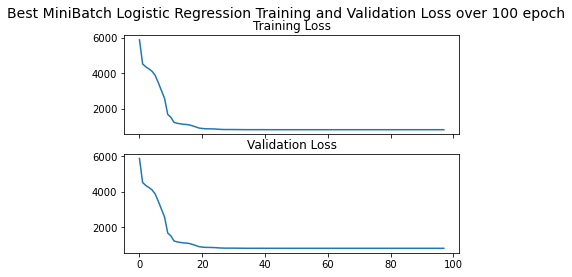

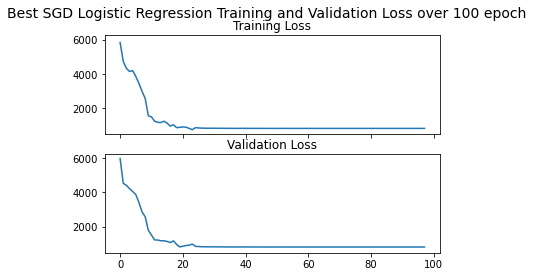

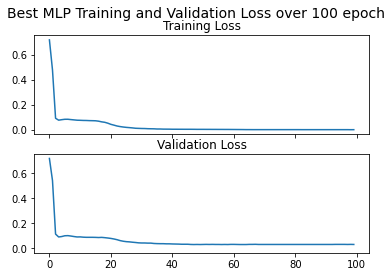

In [10]:
train(clean_data, label_list)

## Analysis

Overall, these models were fairly successful in classifying paragraphs of text into the three author categories provided. The accuracies for the sgd logistic regression and the mlp model were about the same, at 96%, with the minibatch logistic regression at 95%. The training was completed over 100 epochs. Looking at the loss graphs, it seems as though neither model needed to train for that many epochs. Maybe 20 or 25 epochs would have worked for optimal performance. Training for too many epochs may lead to overfitting for this given dataset, and it is unknown whether these results will translate to other books written by the same authors. Because the accuracies, precision, and recall were so high for both the MLP and Linear Regression models, I think it is safe to say that either model would work well for classifying these paragraphs. While the classification performance for `Jane Austen` and `Fyodor Dostoyevsky` were relatively high at around 95-96% for both models, the accuracy for `Arthur Conan Doyle` was lower at around 80-86%. This is probably due to only having 581 paragraph examples (see the output of the `clean` function), whereas the other two authors have 2497 and 5840 respectively. With more paragraph examples, I am sure that this accuracy will increase. The reason why there are less paragraph examples for `Arthur Conan Doyle` is because Sherlock Holmes has a lot of back-and-forth dialogue, which I attribute to one paragraph of text as opposed to multiple. If more complicated logic was implemented to split the text into shorter - but more accurate - paragraphs, there will be more paragraph examples for `Arthur Conan Doyle`, and most likely better model performance.

In conclusion, both of these models performed well in classifying paragraphs between these three authors. More training data will almost certainly increase the overall performance of both models. It remains to be seen whether these models will perform well with completely unrelated texts written by the same authors (as opposed to within the same book), or if the models can distinguish between additional authors.